In [4]:
# !pip install tensorflow==2.8.0
!pip install efficientnet
!pip install --upgrade wandb
!pip install boto3

In [5]:
import os
import re
import random
import pandas as pd
import numpy as np
import json
import math
import string
import uuid


### Tensorflow Imports
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,confusion_matrix
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, Layer, \
                        UpSampling1D, Input, DepthwiseConv2D, Conv2D, \
                        BatchNormalization, ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras.applications import MobileNet


### External models
import efficientnet.tfkeras as efn


### Matplotlib Imports
import matplotlib
import matplotlib.pyplot as plt


### import wandb
import wandb
from wandb.keras import WandbCallback

### Kaggle specific imports
if os.environ.get('KAGGLE_DOCKER_IMAGE', None):
    from kaggle_datasets import KaggleDatasets
    DATA_PATH = KaggleDatasets().get_gcs_path()
    DATA_PATH = DATA_PATH + '/mitdb128x128'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [6]:
import boto3
import os
from botocore import UNSIGNED
from botocore.config import Config


def download_files(bucket_name, s3_prefix, local_directory):
    s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
    bucket = s3.Bucket(bucket_name)

    for obj in bucket.objects.filter(Prefix=s3_prefix):
        local_file = os.path.join(local_directory, obj.key)

        if not os.path.exists(os.path.dirname(local_file)):
            os.makedirs(os.path.dirname(local_file))

        bucket.download_file(obj.key, local_file)
        print(f"Downloaded {obj.key} to {local_file}")

download_files('mitdb128x128', 'train', '/content/input')

Downloaded trainfile_class10_fold0_6117.tfrec to /content/input/trainfile_class10_fold0_6117.tfrec
Downloaded trainfile_class10_fold1_6116.tfrec to /content/input/trainfile_class10_fold1_6116.tfrec
Downloaded trainfile_class10_fold2_6116.tfrec to /content/input/trainfile_class10_fold2_6116.tfrec
Downloaded trainfile_class10_fold3_6116.tfrec to /content/input/trainfile_class10_fold3_6116.tfrec
Downloaded trainfile_class10_fold4_6116.tfrec to /content/input/trainfile_class10_fold4_6116.tfrec
Downloaded trainfile_class10_fold5_6116.tfrec to /content/input/trainfile_class10_fold5_6116.tfrec
Downloaded trainfile_class10_fold6_6116.tfrec to /content/input/trainfile_class10_fold6_6116.tfrec
Downloaded trainfile_class10_fold7_6117.tfrec to /content/input/trainfile_class10_fold7_6117.tfrec
Downloaded trainfile_class10_fold8_6116.tfrec to /content/input/trainfile_class10_fold8_6116.tfrec
Downloaded trainfile_class10_fold9_6116.tfrec to /content/input/trainfile_class10_fold9_6116.tfrec


In [7]:
hparams = {
    "backbone" : "b0",
    "batch_size" : 32,
    "epochs" : 40,
    "img_size" : 128,
    "lr" : 0.01,
    "optimizer" : "adam",
    "seed": 257
}

In [8]:
class WandBConfigurations():
    def __init__(self, exp_name = "ECG_BEAT_CLASSIFICATION_PAPER_COMMENTS"):
        self.EXPERIMENT_NAME = exp_name
        os.environ["WANDB_API_KEY"] = "221507f411c2ddcc0c17238e115a12c528a482f6"
        wandb.login()

WB = WandBConfigurations()

wandb: Currently logged in as: shreya-srivas02. Use `wandb login --relogin` to force relogin


In [9]:
 class Utils():
    def __init__(self):
        self.seed_everything()

    def id_generator(size=6):
        return str(uuid.uuid4())[:size]

    def setupTPU(self):

        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            print('Running on TPU ', tpu.cluster_spec().as_dict())
        except ValueError:
            tpu = None

        if tpu:
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.TPUStrategy(tpu)
            STRATEGY = strategy
            BATCH_SIZE = 8 * strategy.num_replicas_in_sync
            # wandb.config.hardware = 'TPU'
        else:
            strategy = tf.distribute.get_strategy()
            
        return strategy

    def seed_everything(self):
        np.random.seed(hparams['seed'])
        tf.random.set_seed(hparams['seed'])
        random.seed(a=hparams['seed'])
        os.environ['PYTHONHASHSEED'] = str(hparams['seed'])

UTILS = Utils()
STRATEGY = UTILS.setupTPU()

In [10]:
STRATEGY

In [11]:
class Config():
    def __init__(self):
        self.DO_VAL_SPLIT = True
        self.TRAIN_FILES = sorted(tf.io.gfile.glob('/content/input/train*.tfrec'))[:-1]
        self.TOTAL_TRAIN_IMG = 48929
        self.TOTAL_VAL_IMG = 6116
        self.TOTAL_TEST_IMG = 6116
        self.BACKBONE = hparams['backbone']
        self.IMG_TRAIN_SHAPE = [hparams["img_size"],hparams["img_size"]]
        self.DO_FINETUNE = True
        self.BATCH_SIZE = hparams["batch_size"] # 16
        self.EPOCHES = hparams["epochs"]
        self.SEED = hparams["seed"]
        self.LOSS = tf.keras.losses.CategoricalCrossentropy()
        self.OPTIMIZER = self.get_optimizer()
        self.ACCURACY = []
        self.CALLBACKS = []
        self.STRATEGY = STRATEGY
        self.FOLDS = 9
        self.USE_LR_SCHEDULER = True
        self.FOLD_NUMBER = 0
        self.FOLDS_DICT = {}

        if self.USE_LR_SCHEDULER:
            lrfn = self.get_cosine_schedule_with_warmup(lr=hparams['lr'])
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)
            self.CALLBACKS.append(lr_schedule)

    def get_optimizer(self):
        if hparams['optimizer'] == 'adam':
            return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'rmsprop':
            return tf.keras.optimizers.RMSprop(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'adagrad':
            return tf.keras.optimizers.Adagrad(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'adadelta':
            return tf.keras.optimizers.Adadelta(learning_rate=hparams["lr"])

        return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])

    def get_cosine_schedule_with_warmup(
        self,
        lr = 0.00004,
        num_warmup_steps = 0,
        num_cycles=0.5):
        num_training_steps = self.EPOCHES
        def lrfn(epoch):
            if epoch < num_warmup_steps:
                return (float(epoch) / float(max(5, num_warmup_steps))) * lr
            progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

        return lrfn


CONFIG = Config()

In [12]:
CONFIG.TRAIN_FILES

['/content/input/trainfile_class10_fold0_6117.tfrec',
 '/content/input/trainfile_class10_fold1_6116.tfrec',
 '/content/input/trainfile_class10_fold2_6116.tfrec',
 '/content/input/trainfile_class10_fold3_6116.tfrec',
 '/content/input/trainfile_class10_fold4_6116.tfrec',
 '/content/input/trainfile_class10_fold5_6116.tfrec',
 '/content/input/trainfile_class10_fold6_6116.tfrec',
 '/content/input/trainfile_class10_fold7_6117.tfrec',
 '/content/input/trainfile_class10_fold8_6116.tfrec']

In [13]:
class Data():
    def __init__(self):
        self.LABELED_TFREC_FORMAT = {
            "image_id": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            'target10': tf.io.FixedLenFeature([], tf.int64),
            'gender' : tf.io.FixedLenFeature([], tf.int64),
            'age_interval' : tf.io.FixedLenFeature([], tf.int64),
        }

    def process_training_data(self, data_file):
        data = tf.io.parse_single_example(data_file, self.LABELED_TFREC_FORMAT)
        img = tf.image.decode_jpeg(data['image'], channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*CONFIG.IMG_TRAIN_SHAPE, 1])

        age = tf.cast(data['age_interval'], tf.float32) / 10.0
        sex = tf.cast(data['gender'], tf.float32) / 1.0
        tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
        tabular_data = tf.stack(tab_data)

        target10 = tf.one_hot(data['target10'], depth=10)

        return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10 }

    def process_testing_data(self, data_file):
        data = tf.io.parse_single_example(data_file, self.LABELED_TFREC_FORMAT)
        img = tf.image.decode_jpeg(data['image'], channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*CONFIG.IMG_TRAIN_SHAPE, 1])

        age = tf.cast(data['age_interval'], tf.float32) / 10.0
        sex = tf.cast(data['gender'], tf.float32) / 1.0
        tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
        tabular_data = tf.stack(tab_data)

        target10 = tf.one_hot(data['target10'], depth=10)
        image_id = data["image_id"]

        return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10, "image_id":  data['image_id']}

    def val_dataset(self):
        ignore_order = tf.data.Options()
        val_dataset = (
            tf.data.TFRecordDataset(
                sorted(tf.io.gfile.glob('/content/input/train*.tfrec'))[-1],
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_training_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).batch(
                CONFIG.BATCH_SIZE
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )

        return val_dataset

    def train_dataset(self):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        train_dataset = (
            tf.data.TFRecordDataset(
               sorted(tf.io.gfile.glob('/content/input/train*.tfrec'))[-1],
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_training_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).repeat(
            ).shuffle(
                CONFIG.SEED
            ).batch(
                CONFIG.BATCH_SIZE
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )

        return train_dataset

    def test_dataset(self):
        ignore_order = tf.data.Options()
        TEST_FILES = sorted(tf.io.gfile.glob('/content/input/train*.tfrec'))[-1]
        test_dataset = (
            tf.data.TFRecordDataset(
                TEST_FILES,
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_testing_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).batch(
                CONFIG.BATCH_SIZE *  4
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )
        return test_dataset


In [14]:
NAME = ['/', "A",  'F', 'L', 'N', 'R', 'V', 'a', 'f', 'j']

In [15]:
run = wandb.init()
artifact = run.use_artifact('shreya-srivas02/ECG_BEAT_CLASSIFICATION_PAPER_COMMENTS/model-whole-jazz-161:v13', type='model')
artifact_dir = artifact.download()

new_model = tf.keras.models.load_model('/kaggle/working/artifacts/model-whole-jazz-161:v13')

# print(new_model.summary())

XX = new_model.input 
YY = new_model.layers[-3].output
new_model2 = tf.keras.models.Model(XX, YY)

DATA = Data()
test_dataset = DATA.test_dataset().map(lambda data, ids: data)

STEPS = 6116//128 + 1
predict = new_model2.predict(test_dataset, steps=STEPS)

test_dataset = DATA.test_dataset().map(lambda data, ids: data)
img_labels_ds = DATA.test_dataset().map(lambda data, ids: ids).unbatch()
test_labels = next(iter(img_labels_ds.batch(6116 + 1)))
labels = np.argmax(test_labels['target10'].numpy(), axis=1)


wandb:   5 of 5 files downloaded.  


48/48 [==============================] - 4s 33ms/step


In [16]:
single_data = next(iter(test_dataset))

## occlusion_sensitivity_multimodal

1/1 [==============================] - 0s 490ms/step


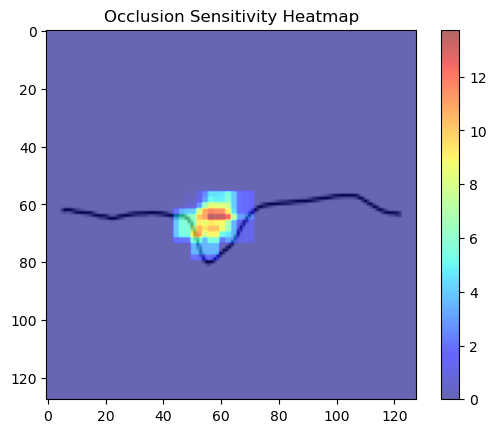

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def occlusion_sensitivity_multimodal(model, image, metadata, patch_size, stride, neutral_value=0):
    # Image dimensions
    height, width, _ = image.shape
    # Store output scores for each occluded image
    output_scores = []
    # Store coordinates for heatmap
    heatmap_coords = []
    
    for h in range(0, height - patch_size + 1, stride):
        for w in range(0, width - patch_size + 1, stride):
            occluded_image = image.copy()
            occluded_image[h:h+patch_size, w:w+patch_size, :] = neutral_value
            # Replicate the metadata for the current occluded image
            output = model.predict([np.expand_dims(occluded_image, axis=0), np.expand_dims(metadata, axis=0)], verbose=0)
            output_scores.append(output)
            heatmap_coords.append((h, w))
    
    return np.array(output_scores), heatmap_coords

def plot_heatmap(image, outputs, coords, patch_size, original_output):
    heatmap = np.zeros_like(image[:, :, 0])
    for i, (h, w) in enumerate(coords):
        # Compute the absolute difference between occluded output and the original output
        difference = np.abs(outputs[i][0] - original_output[0])
        
        # If your output is multi-dimensional (e.g., softmax probabilities),
        # you might want to sum the differences or take an L2 norm:
        summed_difference = np.sum(difference)
        
        heatmap[h:h+patch_size, w:w+patch_size] += summed_difference

    plt.imshow(image, cmap='gray')  # Assuming ECG images are grayscale
    plt.imshow(heatmap, alpha=0.6, cmap='jet')
    plt.colorbar()
    plt.title("Occlusion Sensitivity Heatmap")
    plt.show()


image = single_data["inp1"].numpy()[123]
metadata = single_data["inp2"].numpy()[123]

patch_size = 10
stride = 2
original_output = new_model.predict([np.expand_dims(image, axis=0), np.expand_dims(metadata, axis=0)])
outputs, coords = occlusion_sensitivity_multimodal(new_model, image, metadata, patch_size, stride)

# Visualize the results
plot_heatmap(image, outputs, coords, patch_size, original_output)

## Turn OFF Age and see the prediction difference

4/4 [==============================] - 0s 8ms/step


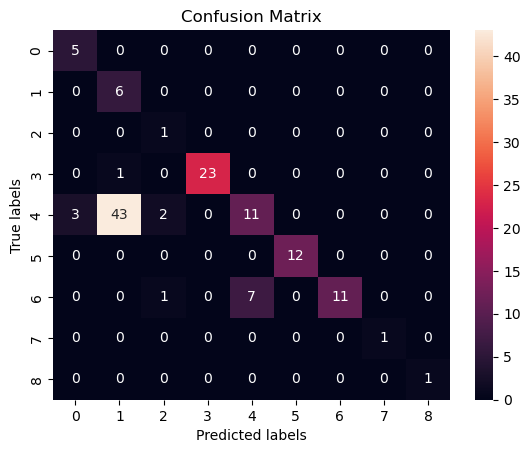

In [17]:
img2 = np.expand_dims(single_data["inp1"].numpy()[13], axis=0)
metadata2 = np.expand_dims(single_data["inp2"].numpy()[13], axis=0)

img2 = single_data["inp1"].numpy()
metadata2 = single_data["inp2"].numpy()

metadata3 = metadata2.copy()
for i in range(len(metadata3)):
    metadata3[i,0] = 0.0

def get_feature_maps(model, image, metadata):
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.output)
    return intermediate_layer_model.predict([image, metadata])

# Original feature maps
original_maps = get_feature_maps(new_model, img2, metadata2)

# Occluded feature maps
occluded_maps = get_feature_maps(new_model, img2, metadata3)

# Compute difference
difference_maps = original_maps - occluded_maps

from sklearn.metrics import confusion_matrix
import pylab as pl

cm = confusion_matrix(labels[:128], np.argmax(difference_maps, axis=1))
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

## Same as confusion matrix but different perspective

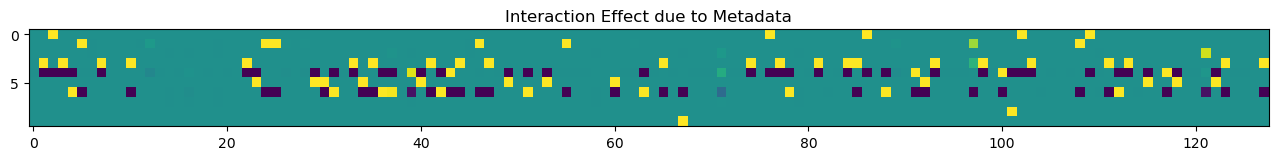

In [18]:
plt.figure(figsize=(16, 8))
plt.imshow(difference_maps.T)
# plt.colorbar()
plt.title('Interaction Effect due to Metadata')
plt.show()

In [19]:
def get_feature_maps(model, image, metadata):
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-5].output)
    return intermediate_layer_model.predict([image, metadata])

# Original feature maps
original_maps = get_feature_maps(new_model, img2, metadata2)

# Occluded feature maps
occluded_maps = get_feature_maps(new_model, img2, np.zeros_like(metadata2))

# Compute difference
difference_maps = original_maps - occluded_maps

4/4 [==============================] - 1s 8ms/step


In [20]:
original_maps.shape

(128, 128)

In [21]:
img = img2[0]

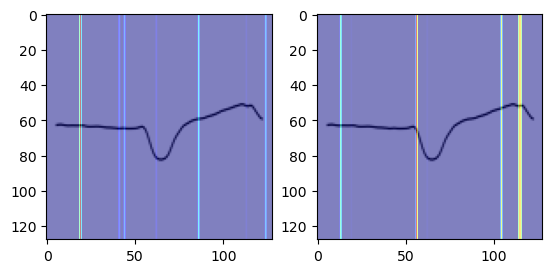

In [22]:
idx = 33

img = np.expand_dims(single_data["inp1"].numpy()[idx], axis=0)
metadata = np.expand_dims(single_data["inp2"].numpy()[idx], axis=0)

activation_2d = np.tile(occluded_maps[idx][:, np.newaxis], (1, 128))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img, cmap="gray")
ax[0].imshow(activation_2d.T, cmap='jet', alpha=0.5)

activation_2d = np.tile(original_maps[idx][:, np.newaxis], (1, 128))

ax[1].imshow(img, cmap="gray")
ax[1].imshow(activation_2d.T, cmap='jet', alpha=0.5)
plt.show()

## Before SACC and After SACC

In [25]:
def get_before_sacc_feature_maps(model, image, metadata):
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-9].output)
    return intermediate_layer_model.predict([image, metadata])

def get_after_sacc_feature_maps(model, image, metadata):
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-5].output)
    return intermediate_layer_model.predict([image, metadata])

In [62]:
labels[:128]

array([4, 3, 0, 3, 6, 1, 6, 3, 4, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 5, 1, 1, 4, 6, 4, 5, 5, 6, 4, 3, 5, 3, 6, 6, 4, 4, 5, 3, 6, 4,
       3, 4, 1, 3, 4, 5, 4, 6, 4, 5, 4, 1, 4, 4, 4, 6, 5, 4, 4, 6, 4, 3,
       4, 9, 4, 4, 4, 6, 4, 4, 3, 4, 0, 3, 6, 4, 4, 3, 6, 4, 3, 3, 0, 4,
       6, 4, 4, 4, 5, 3, 4, 4, 4, 3, 3, 4, 4, 8, 0, 3, 6, 4, 4, 4, 1, 0,
       4, 3, 6, 3, 6, 5, 4, 4, 5, 4, 4, 2, 5, 3, 4, 4, 6, 3])

4/4 [==============================] - 0s 8ms/step


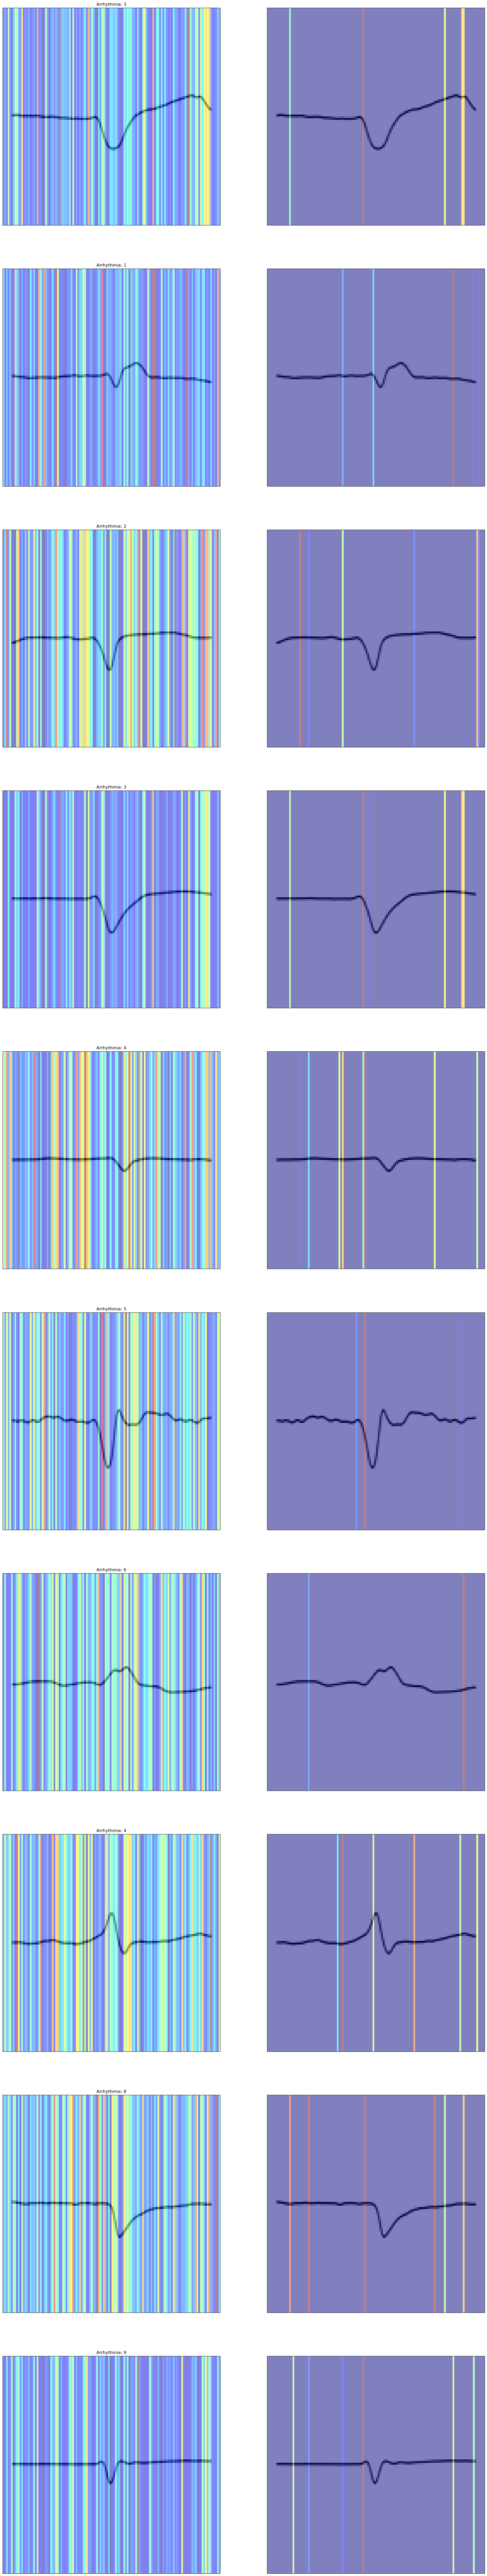

In [66]:
# Original feature maps

idxs = [33, 5, 121, 1, 0, 23, 4, 21, 101, 67]
# idxs = [1, 2]

img = single_data["inp1"].numpy()
metadata = single_data["inp2"].numpy()

b_map = get_before_sacc_feature_maps(new_model, img, metadata)
a_map = get_after_sacc_feature_maps(new_model, img, metadata)

fig, ax = plt.subplots(nrows=len(idxs), ncols=2, figsize=(24, 128))
for cnt, idx in enumerate(idxs):
    activation_2d = np.tile(b_map[idx][:, np.newaxis], (1, 128))

    
    ax[cnt][0].imshow(img[idx], cmap="gray")
    ax[cnt][0].imshow(activation_2d.T, cmap='jet', alpha=0.5)
    ax[cnt][0].set_xticks([])
    ax[cnt][0].set_yticks([])

    activation_2d = np.tile(a_map[idx][:, np.newaxis], (1, 128))

    ax[cnt][1].imshow(img[idx], cmap="gray")
    ax[cnt][1].imshow(activation_2d.T, cmap='jet', alpha=0.5)
    ax[cnt][1].set_xticks([])
    ax[cnt][1].set_yticks([])
    ax[cnt][0].set_title(f"Arrhythmia: {labels[idx]}")

4/4 [==============================] - 0s 5ms/step


Text(0.5, 0.98, 'Arrhythmia: 3')

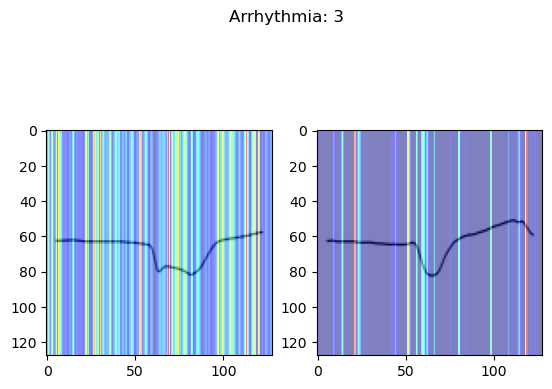

In [39]:
# Original feature maps
idx = 2
img = img2[idx]
metadata = 
b_map = get_before_sacc_feature_maps(new_model, img, metadata2)


activation_2d = np.tile(b_map[idx][:, np.newaxis], (1, 128))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img, cmap="gray")
ax[0].imshow(activation_2d.T, cmap='jet', alpha=0.5)

a_map = get_after_sacc_feature_maps(new_model, img, metadata2)

idx = 33
img = img2[idx]
activation_2d = np.tile(a_map[idx][:, np.newaxis], (1, 128))

ax[1].imshow(img, cmap="gray")
ax[1].imshow(activation_2d.T, cmap='jet', alpha=0.5)
fig.suptitle(f"Arrhythmia: {labels[idx]}")

4/4 [==============================] - 0s 8ms/step


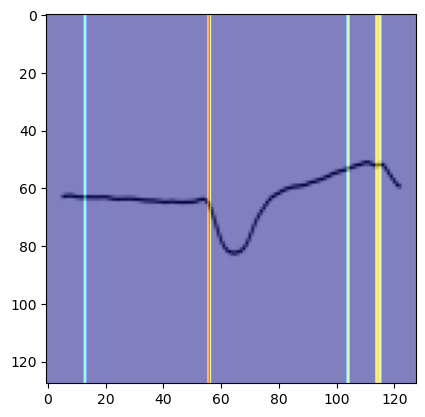

In [29]:
# Original feature maps


In [24]:
new_model.layers

## TSNE Vis

48/48 [==============================] - 2s 40ms/step


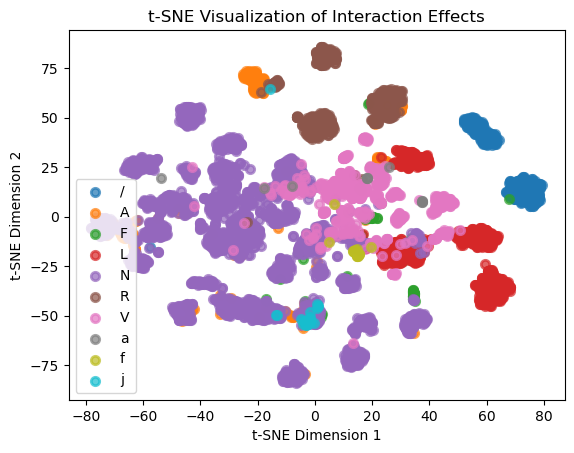

In [21]:
from sklearn.manifold import TSNE

def get_feature_maps(model, data):
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-9].output)
    return intermediate_layer_model.predict(data)

predict = get_feature_maps(new_model, test_dataset)

df = pd.DataFrame(predict)
df[128] = labels

X = df.drop(columns=[128])
y = df[128]

# Compute t-SNE embedding
X_r = TSNE(n_components=2).fit_transform(X)

plt.figure()
# colors = ["navy", "turquoise", "darkorange"]
lw = 2

for i, target_name in zip([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], NAME):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], alpha=0.7, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA[DPN-SACC]")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Interaction Effects')
plt.show()

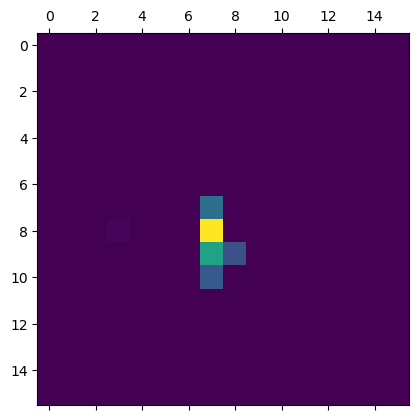

In [22]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming model is your trained model and img_tensor is your preprocessed ECG image tensor
def grad_cam(model, img_tensor, metadata):
    grad_model = tf.keras.models.Model(model.input, [model.layers[-11].output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img_tensor, metadata])
        loss = predictions[:, np.argmax(predictions[0])]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap[0]

img2 = np.expand_dims(single_data["inp1"].numpy()[13], axis=0)
metadata2 = np.expand_dims(single_data["inp2"].numpy()[13], axis=0)

heatmap = grad_cam(new_model, img2, metadata2)
plt.matshow(heatmap)
plt.show()


In [ ]:
new_model.summary